# Reddit Troll Data: Exploratory Data Analysis

Russian troll farms are state-sponsored and they have human operators carrying out deceptive online interference in political campaigns, such as the 2016 US presidential election, and also spread misinformation.

Reddit periodically publishes transparency reports that may contain information on the identification and removal of troll accounts or accounts associated with foreign influence campaigns. The [report](https://www.reddit.com/r/announcements/
comments/8bb85p/reddits_2017_transparency_report_and_suspect/) published in 2017 included data on 900 accounts which were highly suspected of being Russian Trolls. 

The data on user accounts and comments by these users is available in csv format and has been used in academic research. I analyze the data below

## Libraries

In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import json
import re
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
from datetime import datetime
import random
import html
from urllib.parse import urlparse, urlsplit
from math import floor, ceil

# User Accounts Identified as "Russian Trolls" by Reddit

In the following I look at the **911 users** and explore the data that can be retrieved by user. Below I focus on when the accounts were created, whether the accounts have a veriefied email, and the karma of the users. 

In [3]:
# read the data
reddit_a = []
with open('./data/troll_account_data.txt', 'r') as f:
    for line in f:
        try:
            data = json.loads(line)['data']
        except:
            continue
        reddit_a.append(data)

reddit_accounts = pd.DataFrame(reddit_a)
reddit_accounts['datetime_m'] = pd.to_datetime(reddit_accounts['created_utc'], unit='s')

Below we see the first 5 rows of the table `reddit_accounts` that shows the users' data. There are **943 users**. The columns are:

- `is_employee`, indicating whether the user is a Reddit employee
- `icon_img`, provides a link to the user's avatar
- `pref_show_snoovatar`, whether the user prefers to show a customized avatar
- `name`, user name
- `is_friend`, whether a user is friends with an authenticated user
- `has_suscribed`, whether a user has subscribed to any community
- `hide_from_robots`, 
- `created_utc`, UTC for account creation
- `link_karma`, karma received from posts
- `comment_karma`, karma received from comments
- `is_gold`, whether the user has Premium reddit
- `is_mod`, whether the user is a moderator in any subreddit 
- `verified`
- `subreddit`, whether the user has created a subreddit
- `has_verified_email`, whether the user has a verified email account 
- `id`, user unique id
- `is_suspended`
- `datetime_m`, timestamp in which the account was created 

In [4]:
reddit_accounts.head()

,is_employee,icon_img,pref_show_snoovatar,name,is_friend,created,has_subscribed,hide_from_robots,created_utc,link_karma,comment_karma,is_gold,is_mod,verified,subreddit,has_verified_email,id,is_suspended,datetime_m
0,False,https://www.redditstatic.com/avatars/avatar_de...,False,BlackToLive,False,1.467710e+09,True,False,1.467681e+09,1.0,-7.0,False,False,True,"{'default_set': True, 'user_is_contributor': N...",True,z919g,NaN,2016-07-05 01:13:18
1,False,https://www.redditstatic.com/avatars/avatar_de...,False,FaurnFlamebreaker,False,1.431712e+09,False,False,1.431683e+09,1.0,-5.0,False,False,True,"{'default_set': True, 'user_is_contributor': N...",False,nhk4d,NaN,2015-05-15 09:44:41
2,False,https://www.redditstatic.com/avatars/avatar_de...,False,Bill_Jonson,False,1.445083e+09,True,False,1.445054e+09,1.0,-4.0,False,False,True,"{'default_set': True, 'user_is_contributor': N...",False,r8rca,NaN,2015-10-17 03:55:40
3,False,https://www.redditstatic.com/avatars/avatar_de...,False,PurebringerOghmagra,False,1.431722e+09,False,False,1.431694e+09,1.0,0.0,False,False,True,"{'default_set': True, 'user_is_contributor': N...",False,nhml3,NaN,2015-05-15 12:38:42
4,False,https://www.redditstatic.com/avatars/avatar_de...,False,Clawisma,False,1.442453e+09,True,False,1.442424e+09,1.0,-2.0,False,False,True,"{'default_set': True, 'user_is_contributor': N...",False,qidqv,NaN,2015-09-16 17:22:29


In [5]:
reddit_accounts.shape

(943, 19)

In [6]:
reddit_accounts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   is_employee          942 non-null    object        
 1   icon_img             942 non-null    object        
 2   pref_show_snoovatar  942 non-null    object        
 3   name                 943 non-null    object        
 4   is_friend            942 non-null    object        
 5   created              942 non-null    float64       
 6   has_subscribed       942 non-null    object        
 7   hide_from_robots     942 non-null    object        
 8   created_utc          942 non-null    float64       
 9   link_karma           942 non-null    float64       
 10  comment_karma        942 non-null    float64       
 11  is_gold              942 non-null    object        
 12  is_mod               942 non-null    object        
 13  verified             942 non-null  

### When were the accounts created? 

The accounts identified as `Russian Trolls` as were created between May 2010 and January 2018. Interestingly,75.4% of the accounts were created in May 2015, right when the primary presidential elections in the United States were beginning (Clinton officially announced her campagin in April 2015 and Trump in June 2015). The figure below shows the large spike in account creation in May 2015, while there were other smaller ones in the following months leading to the primaries and the presidential election in November 2016.

In [7]:
reddit_accounts.datetime_m.min(), reddit_accounts.datetime_m.max()

(Timestamp('2010-05-28 07:44:27'), Timestamp('2018-01-13 10:43:28'))

In [8]:
# function to calculate number of user accounts created by month
def get_counts_month(df, key, user_key):
    df['datetime'] = pd.to_datetime(df[key])
    df = df[[user_key,key, 'datetime']].drop_duplicates()    
    start_date = '2010-05-01'
    end_date = '2018-01-31'
    counts_month = df[[user_key, 'datetime']].groupby(pd.Grouper(key='datetime', freq='w')).count()
    counts_month.index = pd.DatetimeIndex(counts_month.index)
    idx = pd.date_range(start_date, end_date, freq='w')
    counts_month = counts_month.reindex(idx, fill_value=0)
    return counts_month

In [9]:
# plot for time-series which also adds months in which zero accounts were created for better time series
def plot_days_counts_agg(list_days_and_counts, path, leg, colors, lines):
    fig, ax = plt.subplots(figsize=(12,4.5))

    k=0
    for days_and_counts in list_days_and_counts:
        counts = [x[0] for x in days_and_counts]
        days = [datetime.strptime(x[1], '%d-%m-%Y') for x in days_and_counts]
        days2 = mdates.date2num(days)
        ax.plot_date(days2, counts, colors[k], linestyle=lines[k])
        k+=1

    months = mdates.MonthLocator(range(1,13), bymonthday=1, interval=3)
    monthsFmt = mdates.DateFormatter("%m/%y")     
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(monthsFmt)
    ax.autoscale_view()

    fig.autofmt_xdate()
    plt.ylabel('# of accounts created')
    plt.grid()
    plt.xticks(rotation=40)
    plt.legend(leg, loc='best', fontsize=13)
    plt.margins(x=0)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_horizontalalignment('center')
    for item in ([ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    plt.savefig(path, bbox_inches='tight')
    plt.show()

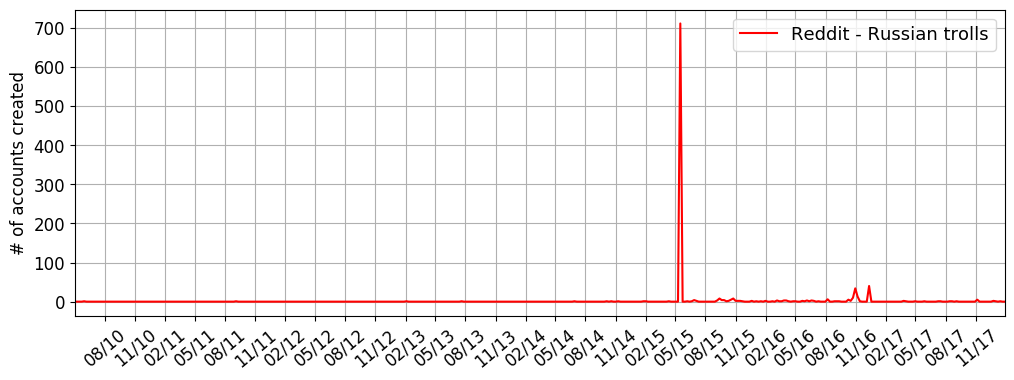

In [10]:
counts_month = get_counts_month(reddit_accounts, 'datetime_m', 'name')
counts_per_day4 = counts_month['name'].tolist()
days4 = counts_month.index.date.tolist()
filter_days = [ (i, j.strftime('%d-%m-%Y')) for (i,j) in zip(counts_per_day4, days4) ]

plot_days_counts_agg([filter_days], path='./figures_users/counts_created_accounts_week_agg.pdf',
                    colors="red", lines="-", 
                    leg=['Reddit - Russian trolls'])



In [11]:
# percentage of accounts that were created in May 2015
round(counts_month.max()/len(reddit_accounts)*100, 2)

name    75.4
dtype: float64

## Were the accounts verified?

While there is no information on how many reddit accounts have a verified email, from the users identified as Russian Trolls, only 196 (21%) have a verified email. 

In [12]:
print('Account has a verified email')
reddit_accounts.has_verified_email.value_counts()

Account has a verified email


False    742
True     196
Name: has_verified_email, dtype: int64

## Users' Karma

Users can receive `karma` creating a post in a subreddit (`link karma`) or commenting in a post (`comment karma`). Karma is calculated from the votes other users give by voting up or down a post or comment, meaning that karma can be negative or positive. Karma is also cumulative as it adds up all karma from posts and comments from a user.

The minimum link karma is 1 and the maximum is 99493, with 72.43% users (613) having a link karma of 1 which can possibly mean they never created a post.  

The minimum comment karma is -20 and the maximum is 32373, with 86.5% users (816) having a comment karma of 0. 

In [13]:
print('Comment Karma of Users')
reddit_accounts.comment_karma.value_counts().sort_index()

Comment Karma of Users


-20.0       3
-14.0       1
-10.0       1
-8.0        2
-7.0        2
           ..
 3072.0     1
 3275.0     1
 4406.0     1
 4899.0     1
 32373.0    1
Name: comment_karma, Length: 79, dtype: int64

In [14]:
print('Users with Comment Karma = 0')
reddit_accounts.comment_karma.value_counts().sort_index().max()

Users with Comment Karma = 0


816

In [15]:
reddit_accounts.comment_karma.describe()

count      942.000000
mean        70.376858
std       1095.636896
min        -20.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      32373.000000
Name: comment_karma, dtype: float64

In [16]:
karma_counts = pd.DataFrame(reddit_accounts.comment_karma.value_counts().reset_index().rename(columns={"index": "comment_karma", "comment_karma": "count"}))
karma_counts.sort_values(by = ["comment_karma"])

,comment_karma,count
7,-20.0,3
56,-14.0,1
66,-10.0,1
16,-8.0,2
12,-7.0,2
...,...,...
37,3072.0,1
78,3275.0,1
77,4406.0,1
53,4899.0,1


In [17]:
reddit_accounts.link_karma.value_counts().reset_index().rename(columns={"index": "link karma", "link_karma": "count"})

,link karma,count
0,1.0,683
1,11.0,7
2,6.0,6
3,7.0,6
4,23.0,5
...,...,...
187,260.0,1
188,241.0,1
189,236.0,1
190,68.0,1


In [18]:
reddit_accounts.link_karma.describe()

count      942.000000
mean       629.769639
std       4454.341919
min          1.000000
25%          1.000000
50%          1.000000
75%          7.000000
max      99493.000000
Name: link_karma, dtype: float64

In [19]:
reddit_accounts.link_karma.value_counts().reset_index().rename(columns={"index": "link karma", "link_karma": "count"})


,link karma,count
0,1.0,683
1,11.0,7
2,6.0,6
3,7.0,6
4,23.0,5
...,...,...
187,260.0,1
188,241.0,1
189,236.0,1
190,68.0,1


## Users' Comments

The tables include 6,711 comments from Russian trolls and 45,131 random comments from other users. 

The random comments from other users comes from a Google BigQuery dataset of normal Reddit user comments from 2015 to
2018. These comments are random samples so I am assuming these for comparison. I use the file used on the paper `Identifying Russian Trolls on Reddit with Deep Learning and BERT Word Embeddings`. 

In [20]:
# Comments from the Russian Trolls
troll_df = pd.read_csv("./data/troll_comments.csv", on_bad_lines='skip')

# Random selection of comments from other users for comparison 
other_df = pd.read_csv("./data/nontroll_comments.csv", on_bad_lines='skip')

/Users/connie/.pyenv/versions/3.7.5/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (1,2,3,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [21]:
troll_df.shape, other_df.shape

((6711, 28), (45143, 20))

In [22]:
troll_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6711 entries, 0 to 6710
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   fullname                         6711 non-null   object 
 1   archived                         6711 non-null   bool   
 2   author.name                      6711 non-null   object 
 3   author_flair_text                807 non-null    object 
 4   body                             6711 non-null   object 
 5   controversiality                 6711 non-null   int64  
 6   created_utc                      6711 non-null   float64
 7   distinguished                    0 non-null      float64
 8   downs                            6711 non-null   int64  
 9   edited                           6711 non-null   object 
 10  gilded                           6711 non-null   int64  
 11  id                               6711 non-null   object 
 12  is_submitter        

In [23]:
other_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45143 entries, 0 to 45142
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   body                    45143 non-null  object 
 1   score_hidden            11985 non-null  object 
 2   archived                11982 non-null  object 
 3   name                    11981 non-null  object 
 4   author                  45131 non-null  object 
 5   author_flair_text       11461 non-null  object 
 6   downs                   11979 non-null  object 
 7   created_utc             45129 non-null  float64
 8   subreddit_id            45129 non-null  object 
 9   link_id                 45129 non-null  object 
 10  parent_id               45129 non-null  object 
 11  score                   45129 non-null  float64
 12  retrieved_on            44990 non-null  float64
 13  controversiality        45129 non-null  float64
 14  gilded                  45129 non-null

### Controversiality of Comments Written by Users

Controversiality is an attribute of comments and takes values 0 and 1. A value of `1` indicates that a comment has received similar number of ups and down votes, so it is a controversial comment. From the data,

- 3.65 % of the troll's comments were controversial
- 2.05% of the random comments were controversial 

Conducting a hypothesis test for difference in proportions with an alpha level of 0.05, we reject the null hypothesis that the two proportions are equal because the p-value is below 0.05.

In [24]:
troll_df['controversiality'].describe()

count    6711.000000
mean        0.036507
std         0.187563
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: controversiality, dtype: float64

In [25]:
other_df['controversiality'].describe()

count    45129.000000
mean         0.020585
std          0.141993
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: controversiality, dtype: float64

In [26]:
print('Number of controversial (1) and non-controversial (0) comments by trolls')
troll_df['controversiality'].value_counts()

Number of controversial (1) and non-controversial (0) comments by trolls


0    6466
1     245
Name: controversiality, dtype: int64

In [27]:
print('Number of controversial (1) and non-controversial (0) comments by non-trolls')
other_df['controversiality'].value_counts()

Number of controversial (1) and non-controversial (0) comments by non-trolls


0.0    44200
1.0      929
Name: controversiality, dtype: int64

In [28]:
from statsmodels.stats.proportion import proportions_ztest

success_cnts = np.array([245, 929])
total_cnts = np.array([len(troll_df['controversiality']), len(other_df['controversiality'])])
test_stat, pval = proportions_ztest(count=success_cnts, nobs=total_cnts, alternative='two-sided')
print('Two sided z-test: z = {:.4f}, p value = {:.4f}'.format(test_stat, pval))

Two sided z-test: z = 8.1845, p value = 0.0000


### Score of Comments, based on Ups and Down Votes

The `ups` and `down` attributes do not have vote counts for up and down votes. It used to have those counts but it was deprecated, so now `ups` has the final score (ups + down votes), while `down` is just 0 for all comments.

From summaries below, we see the scores were:

- Troll users: The minimum score is -147 and the maximum score, 22872. The average score is 17.6 and the median score, 1.

- Non-Troll users: The minimum score is -91 and the maximum score, 4490. The average score is 5.48 and the median score, 1.

Furthermore, below we have densities of the scores for trolls and non-trolls, which highlight how different the range of values is for the two. Also, we observe that the mayority of the density of the scores for the non-troll comments is around, but while we observe a peak around zero for trolls as well, it's is much smaller.

In [29]:
troll_df['ups'].describe()

count     6711.000000
mean        17.600805
std        493.183702
min       -147.000000
25%          1.000000
50%          1.000000
75%          2.000000
max      22872.000000
Name: ups, dtype: float64

In [30]:
other_df['ups'].describe()

count    31545.000000
mean         5.485180
std         42.969169
min        -91.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       4490.000000
Name: ups, dtype: float64

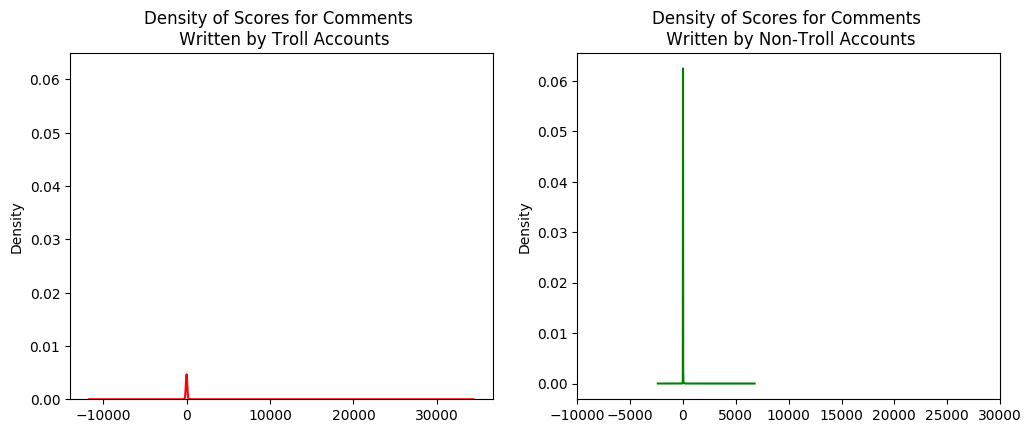

In [31]:
plt.subplots(figsize=(12,4.5))
plt.subplot(1, 2, 1)
plt.title('Density of Scores for Comments \n Written by Troll Accounts')
troll_df.ups.plot.density(color = "red")
plt.ylim([0, 0.065])
plt.subplot(1, 2, 2)
plt.title('Density of Scores for Comments \n Written by Non-Troll Accounts')
plt.xlim([-10000, 30000])
other_df.ups.plot.density(color = "green")

In [32]:
print('Score for comments by trolls')
troll_df['ups'].value_counts().sort_index()

Score for comments by trolls


-147      1
-85       1
-69       1
-44       1
-43       2
         ..
 11917    1
 14097    1
 14925    1
 22007    1
 22872    1
Name: ups, Length: 128, dtype: int64

In [33]:
print('Score for comments by non-trolls')
other_df['ups'].value_counts().sort_index()

Score for comments by non-trolls


-91.0      1
-75.0      1
-66.0      1
-56.0      1
-53.0      1
          ..
 1471.0    1
 1574.0    1
 1662.0    1
 1794.0    1
 4490.0    1
Name: ups, Length: 305, dtype: int64

(array([6.151e+03, 1.000e+00, 1.000e+00, 2.000e+00, 2.000e+00]),
 array([    0. ,  4574.4,  9148.8, 13723.2, 18297.6, 22872. ]),
 <a list of 5 Patch objects>)

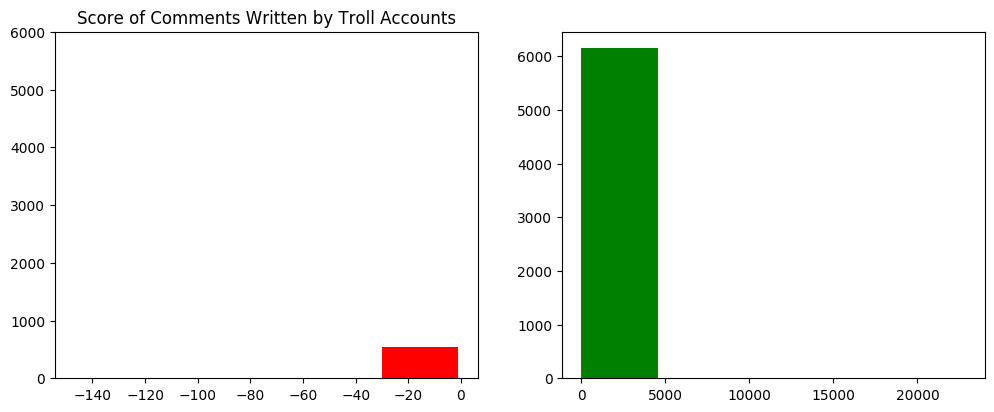

In [34]:
plt.subplots(figsize=(12,4.5))
plt.subplot(1, 2, 1)
plt.hist(troll_df.ups[troll_df.ups < 0], color = 'red', bins=5)
plt.title('Score of Comments Written by Troll Accounts')
plt.ylim(0, 6000)
plt.subplot(1, 2, 2)
plt.hist(troll_df.ups[troll_df.ups >= 0], color = 'green', bins=5)

(array([3.0103e+04, 1.3000e+01, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   0.,  898., 1796., 2694., 3592., 4490.]),
 <a list of 5 Patch objects>)

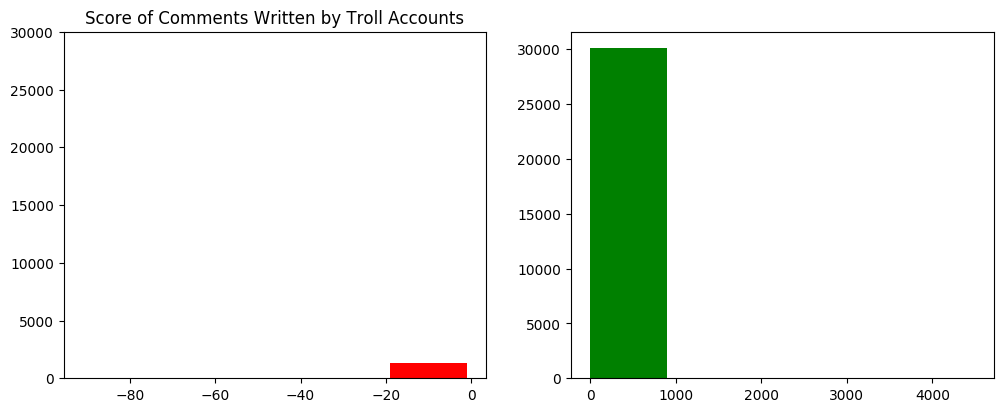

In [35]:
plt.subplots(figsize=(12,4.5))
plt.subplot(1, 2, 1)
plt.hist(other_df.ups[other_df.ups < 0], color = 'red', bins=5)
plt.title('Score of Comments Written by Troll Accounts')
plt.ylim(0, 30000)
plt.subplot(1, 2, 2)
plt.hist(other_df.ups[other_df.ups >= 0], color = 'green', bins=5)

### Comments over Time by Trolls: Looking at the Creation Date

The comments from Trolls accounts were created between March 2014 and April 2018. In April 2018, Reddit shut down the accounts so there are no more comments after April 9, 2018. The figure below shows that the largest activity starts in May 2015, when we also observed the largest amount of accounts created by trolls (over 700 in that month alone). The most activity is leading up to the primary presidential election in early 2016 and leading up to the presidential election at the end of 2016. We also observe a spike in 2018.


In [36]:
troll_df['datetime_m'] = pd.to_datetime(troll_df['created_utc'], unit='s')

troll_df.datetime_m.min(), troll_df.datetime_m.max()

(Timestamp('2014-03-06 09:25:12'), Timestamp('2018-04-09 18:13:42'))

In [37]:
# function to calculate number of user accounts created by month
def get_counts_month(df, key, user_key):
    df['datetime'] = pd.to_datetime(df[key])
    df = df[[user_key,key, 'datetime']].drop_duplicates()    
    start_date = '2014-03-01'
    end_date = '2018-04-30'
    counts_month = df[[user_key, 'datetime']].groupby(pd.Grouper(key='datetime', freq='w')).count()
    counts_month.index = pd.DatetimeIndex(counts_month.index)
    idx = pd.date_range(start_date, end_date, freq='w')
    counts_month = counts_month.reindex(idx, fill_value=0)
    return counts_month
def plot_days_counts_agg(list_days_and_counts, path, leg, colors, lines):
    fig, ax = plt.subplots(figsize=(12,4.5))

    k=0
    for days_and_counts in list_days_and_counts:
        counts = [x[0] for x in days_and_counts]
        days = [datetime.strptime(x[1], '%d-%m-%Y') for x in days_and_counts]
        days2 = mdates.date2num(days)
        ax.plot_date(days2, counts, colors[k], linestyle=lines[k])
        k+=1

    months = mdates.MonthLocator(range(1,13), bymonthday=1, interval=3)
    monthsFmt = mdates.DateFormatter("%m/%y")     
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(monthsFmt)
    ax.autoscale_view()

    fig.autofmt_xdate()
    plt.ylabel('# of comments created')
    plt.grid()
    plt.xticks(rotation=40)
    plt.legend(leg, loc='best', fontsize=13)
    plt.margins(x=0)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_horizontalalignment('center')
    for item in ([ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    plt.savefig(path, bbox_inches='tight')
    plt.show()

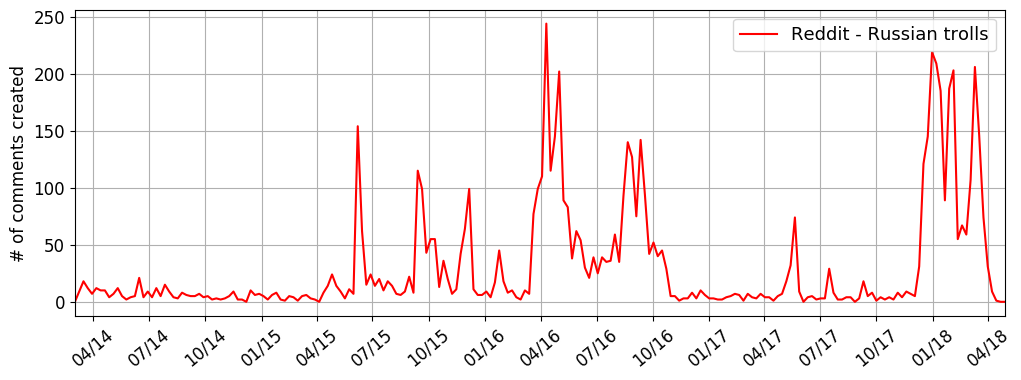

In [38]:
counts_month = get_counts_month(troll_df, 'datetime_m', 'name')
counts_per_day = counts_month['name'].tolist()
days = counts_month.index.date.tolist()
filter_days = [ (i, j.strftime('%d-%m-%Y')) for (i,j) in zip(counts_per_day, days) ]

plot_days_counts_agg([filter_days], path='./figures_users/counts_created_comment_week_agg.pdf',
                    colors="red", lines="-", 
                    leg=['Reddit - Russian trolls'])

### Comments over Time by Non-Trolls: Looking at the Creation Date

The random comments are from 2015 to 2017, but the majority of them were written between January and October 2015.

In [39]:
other_df['datetime_m'] = pd.to_datetime(other_df['created_utc'], unit='s')
other_df.datetime_m.min(), other_df.datetime_m.max()

(Timestamp('2015-01-01 00:18:23'), Timestamp('2017-06-30 22:42:21'))

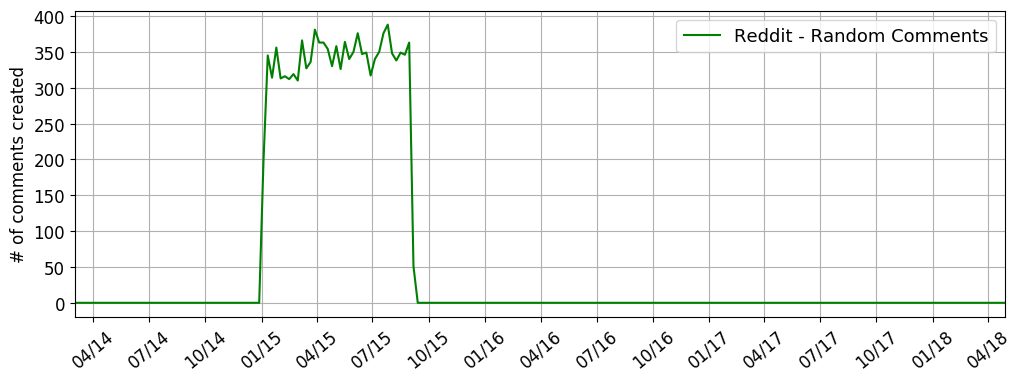

In [40]:
counts_month = get_counts_month(other_df, 'datetime_m', 'name')
counts_per_day = counts_month['name'].tolist()
days = counts_month.index.date.tolist()
filter_days = [ (i, j.strftime('%d-%m-%Y')) for (i,j) in zip(counts_per_day, days) ]

plot_days_counts_agg([filter_days], path='./figures_users/counts_created_comment_week_agg.pdf',
                    colors="green", lines="-", 
                    leg=['Reddit - Random Comments'])


### In which Subreddit were Trolls Most Active?

Below we have the top 20 subreddits for the comments written by trolls (and non-trolls). For trolls, we see subreddits dedicated to politics or news: worldnews, Bad_Cop_No_Donut, politics, news, The_Donald, Conservative. There are also subreddits linked to cryptocurrency (CryptoCurrency, Bitcoin, btc, csgobetting), gaming (pcmasterrace, Steam, GlobalOffensive), and popular topics (funny, aww, pics, gifs, Jokes). The top 1 subreddit is AskReddit which is the most popular subreddit.  

In [41]:
troll_df['subreddit.display_name_prefixed'].value_counts().sort_values(ascending=False).head(20)

r/AskReddit           792
r/CryptoCurrency      581
r/worldnews           269
r/Bad_Cop_No_Donut    221
r/politics            199
r/news                199
r/funny               192
r/newzealand          174
r/pcmasterrace        158
r/Bitcoin             151
r/aww                 139
r/pics                 92
r/gifs                 78
r/Steam                75
r/GlobalOffensive      72
r/btc                  66
r/csgobetting          61
r/The_Donald           60
r/Jokes                59
r/Conservative         57
Name: subreddit.display_name_prefixed, dtype: int64

In [42]:
other_df.subreddit.value_counts().sort_values(ascending=False).head(20)

AskReddit          3190
politics            800
leagueoflegends     570
worldnews           501
funny               487
nba                 461
nfl                 454
news                448
pics                431
videos              424
pcmasterrace        402
The_Donald          398
SquaredCircle       347
soccer              346
todayilearned       340
movies              308
hockey              296
gaming              291
DestinyTheGame      282
DotA2               282
Name: subreddit, dtype: int64